/home/baha/anaconda3/envs/gym-env/lib/python3.10/site-packages/gymnasium/experimental/wrappers/jax_to_numpy.py:75: DeprecationWarning: jax.numpy.DeviceArray is deprecated. Use jax.Array.
  @jax_to_numpy.register(jnp.DeviceArray)
/home/baha/anaconda3/envs/gym-env/lib/python3.10/site-packages/gymnasium/experimental/wrappers/jax_to_torch.py:105: DeprecationWarning: jax.numpy.DeviceArray is deprecated. Use jax.Array.
  @jax_to_torch.register(jnp.DeviceArray)
pybullet build time: Feb  1 2023 20:12:59
2023-11-04 21:31:45.349286: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/baha/anaconda3/envs/gym-env/lib/python3.10/site-packages/cv2/../../lib64::/home/baha/.mujoco/mujoco210/bin
2023-11-04 21:31:45.704566: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynam

b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
block_linkb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
block_link

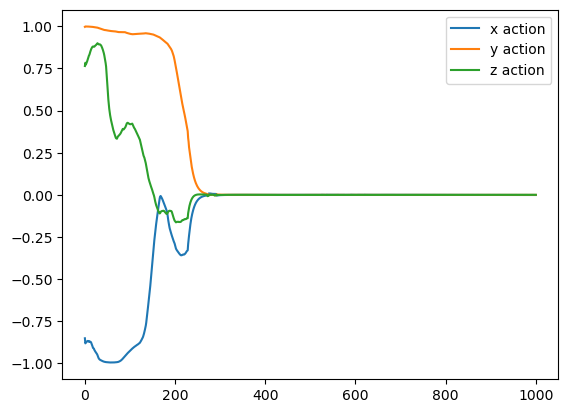

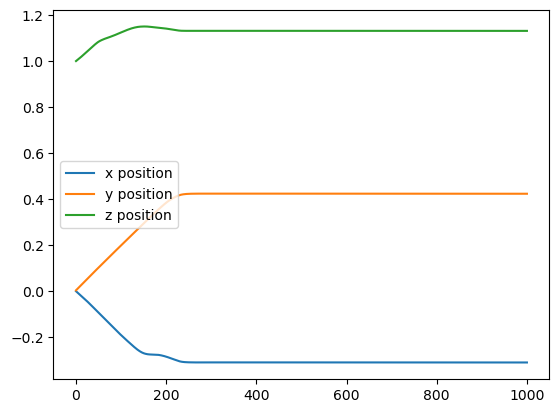

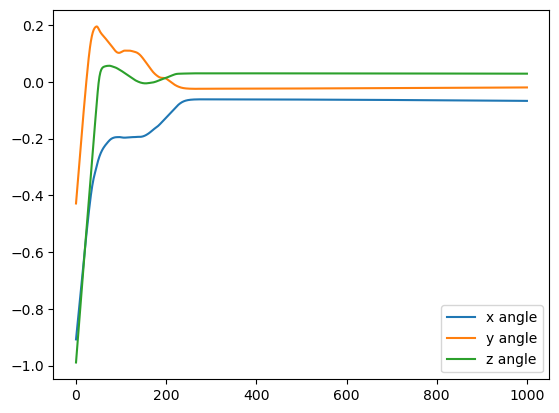

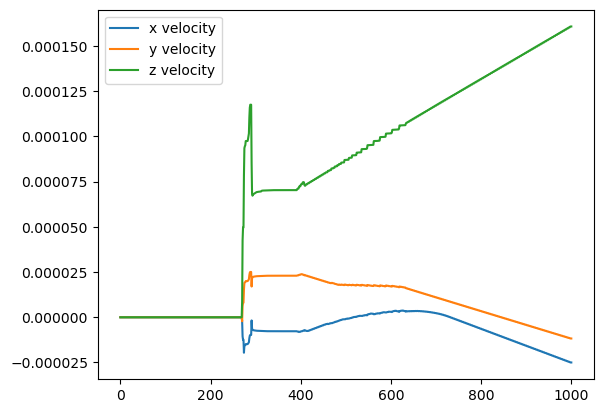

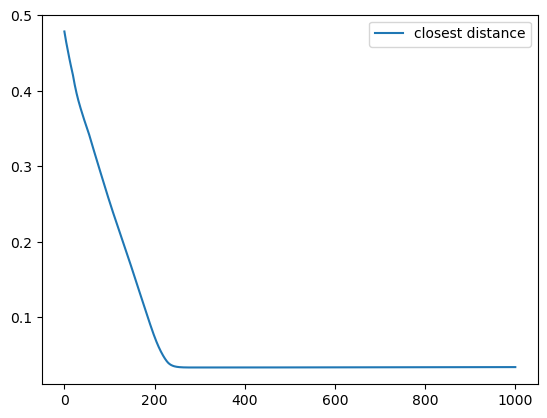

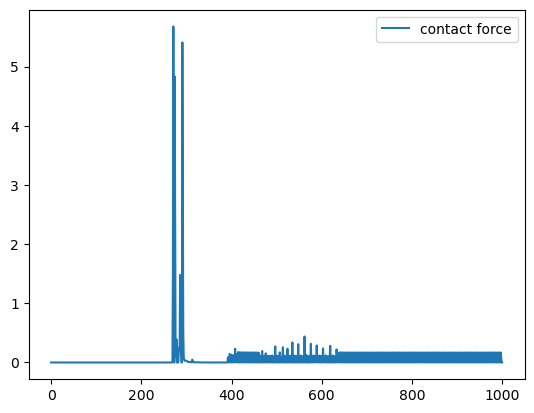

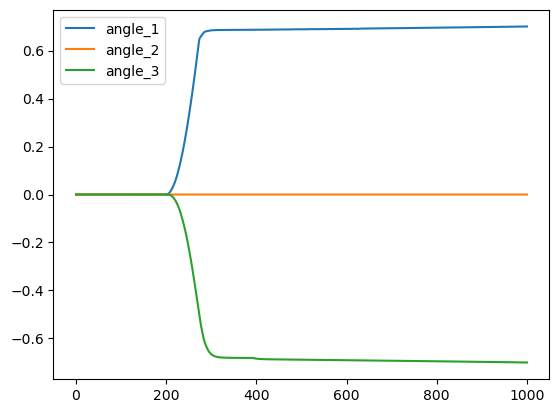

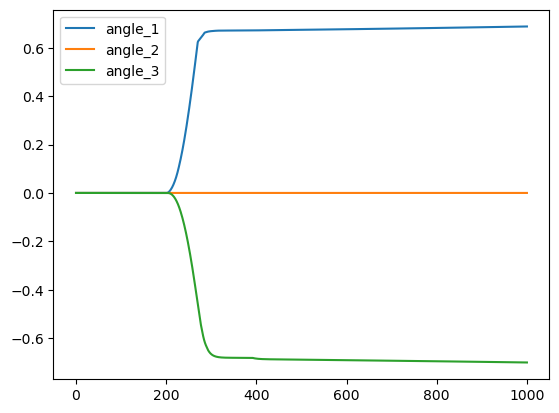

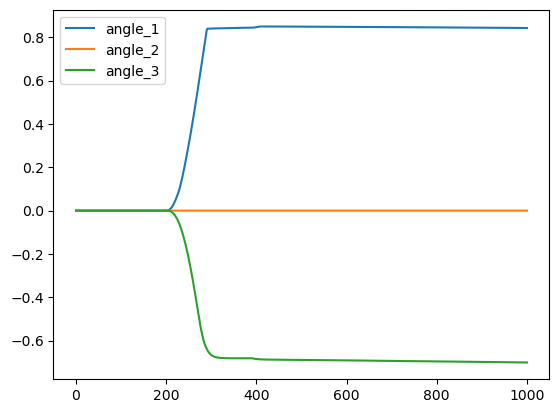

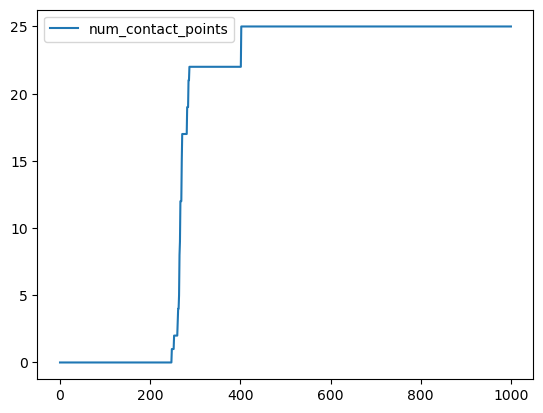

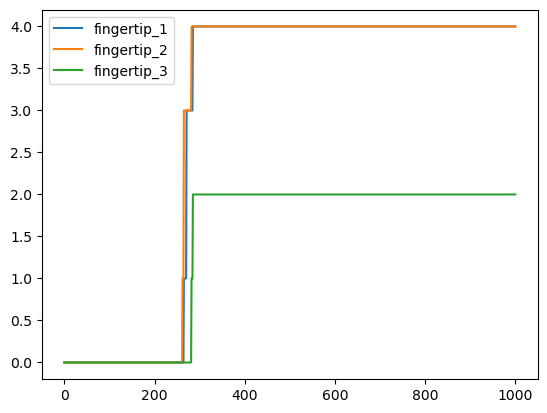

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
import gymnasium
sys.modules["gym"] = gymnasium
import pybullet as p
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from robotiqGymEnv import robotiqGymEnv
import numpy as np
import csv

def load_model(file_path):
    """
    Load the model from the given file path.
    """
    return SAC.load(file_path)

def extract_data(env, model, obs, steps):
    """
    Extract data from the environment.
    """
    data = {
        "position_action": [],
        "angle_action": [],
        "gripper_position": [],
        "gripper_angle": [],
        "gripper_velocity": [],
        "gripper_angular_velocity": [],
        "target_position": [],
        "target_angle": [],
        "target_velocity": [],
        "target_angular_velocity": [],
        "closest_point": [],
        "contact_force": [],
        "rewards": [],
        "finger1_angles": [],
        "finger2_angles": [],
        "finger3_angles": [],
        "finger1_min_dists": [],
        "finger2_min_dists": [],
        "finger3_min_dists": [],
        "num_contact_points": [],
        "fingertip_num_contact_points": []
    }

    done = False
    first_time = True

    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, rewards, done, info = env.step(action)
        
        if rewards > 2:
            if first_time:
                for i in range(env._robotiq.num_joints):
                    #disable default constraint-based motors
                    p.setJointMotorControl2(env._robotiq.robotiq_uid, i, p.POSITION_CONTROL, targetPosition=0, force=0)
                first_time = False
            joint_force = 0.05
            p.setJointMotorControlArray(env._robotiq.robotiq_uid, [1, 5, 9], p.TORQUE_CONTROL, forces=[joint_force, joint_force, joint_force])#, positionGains=[0.03, 0.03, 0.03], velocityGains=[1, 1, 1])
            p.setJointMotorControlArray(env._robotiq.robotiq_uid, [2, 6, 10], p.POSITION_CONTROL, targetPositions=[0, 0, 0])
            j1_angle = p.getJointState(env._robotiq.robotiq_uid, 1)[0]
            p.setJointMotorControlArray(env._robotiq.robotiq_uid, [3, 7, 11], p.POSITION_CONTROL, targetPositions=[-j1_angle, -j1_angle, -j1_angle])
            # p.setJointMotorControlArray(env._robotiq.robotiq_uid, [3, 7, 11], p.TORQUE_CONTROL, forces=[-joint_force, -joint_force, -joint_force])
            # if env._contactinfo()[3] > 0:
            #     p.setJointMotorControlArray(env._robotiq.robotiq_uid, [3, 7, 11], p.TORQUE_CONTROL, forces=[joint_force, joint_force, joint_force])#, positionGains=[0.03, 0.03, 0.03], velocityGains=[1, 1, 1])
        
        base_pos, base_orientation = p.getBasePositionAndOrientation(env._robotiq.robotiq_uid)
        target_pos, target_orientation = p.getBasePositionAndOrientation(env.blockUid)

        base_velocity, base_angular_velocity = p.getBaseVelocity(env._robotiq.robotiq_uid)
        target_velocity, target_angular_velocity = p.getBaseVelocity(env.blockUid)

        gripper_angle = p.getEulerFromQuaternion(base_orientation)
        target_angle = p.getEulerFromQuaternion(target_orientation)

        joint_indices = [1, 2, 3, 5, 6, 7, 9, 10, 11]
        joint_states = p.getJointStates(env._robotiq.robotiq_uid, joint_indices)
        
        for i in range(3):
            data[f"finger{i+1}_angles"].append([joint_states[j][0] for j in range(i*3, (i+1)*3)])

        dist_indices = [1, 2, 3, 5, 6, 7, 9, 10, 11]
        min_dists = [p.getClosestPoints(env.blockUid, env._robotiq.robotiq_uid, 10, -1, i)[0][8] for i in dist_indices]

        for i in range(3):
            data[f"finger{i+1}_min_dists"].append(min_dists[i*3:(i+1)*3])

        data["position_action"].append(action[0:3])
        data["angle_action"].append(action[3:6])
        data["gripper_position"].append(base_pos)
        data["gripper_angle"].append(gripper_angle)
        data["gripper_velocity"].append(base_velocity)
        data["gripper_angular_velocity"].append(base_angular_velocity)
        data["target_position"].append(target_pos)
        data["target_angle"].append(target_angle)
        data["target_velocity"].append(target_velocity)
        data["target_angular_velocity"].append(target_angular_velocity)
        data["closest_point"].append(p.getClosestPoints(env._robotiq.robotiq_uid, env.blockUid, 10, -1, -1)[0][8])
        data["contact_force"].append(env._contactinfo()[5])
        data["num_contact_points"].append(env._contactinfo()[3])
        data["fingertip_num_contact_points"].append(env._contactinfo()[4])
        data["rewards"].append(rewards)
        
        # env.render()
        
    return data

def plot_data(data, labels):
    """
    Plot the data using matplotlib.
    """
    plt.figure()
    for d, label in zip(data, labels):
        plt.plot(d, label=label)
        plt.legend()

def save_to_csv(filename, data):
    """
    Save data to CSV.
    """
    # Find the maximum length among all lists
    max_length = max(len(v) for v in data.values())

    with open(filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)

        # Write header
        headers = list(data.keys())
        csv_writer.writerow(headers)

        # Write rows
        for i in range(max_length):
            row = [data[header][i] if i < len(data[header]) else "" for header in headers]
            csv_writer.writerow(row)

def main():
    """
    Main function to run the program.
    """
    model_file = "models/20230316-03:42PM_SAC/best_model.zip"
    model = load_model(model_file)

    with robotiqGymEnv(records=False, renders=False) as env:
        obs = env.reset()
        steps = range(500)  # Define the number of steps here
        data = extract_data(env, model, obs, steps)

    # Plotting data
    plot_data(zip(*data["position_action"]), ["x action", "y action", "z action"])
    plot_data(zip(*data["gripper_position"]), ["x position", "y position", "z position"])
    plot_data(zip(*data["gripper_angle"]), ["x angle", "y angle", "z angle"])
    plot_data(zip(*data["target_velocity"]), ["x velocity", "y velocity", "z velocity"])
    plot_data([data["closest_point"]], ["closest distance"])
    plot_data([data["contact_force"]], ["contact force"])
    plot_data(zip(*data["finger1_angles"]), ["angle_1", "angle_2", "angle_3"])
    plot_data(zip(*data["finger2_angles"]), ["angle_1", "angle_2", "angle_3"])
    plot_data(zip(*data["finger3_angles"]), ["angle_1", "angle_2", "angle_3"])
    plot_data([data["num_contact_points"]], ["num_contact_points"])
    plot_data(zip(*data["fingertip_num_contact_points"]), ["fingertip_1", "fingertip_2", "fingertip_3"])
    # plot_data(zip(*data["finger2_min_dists"]), ["finger2_min_dist_1", "finger2_min_dist_2", "finger2_min_dist_3"])

    # Saving data to CSV
    save_to_csv("output_data.csv", data)
    

    # Calculating and printing final positions
    gripper_position_data = np.array(data["gripper_position"])
    gripper_final_position = np.mean(gripper_position_data[-100:, :], axis=0)
    target_position_data = np.array(data["target_position"])
    target_final_position = np.mean(target_position_data[-100:, :], axis=0)

    D = 2628.9
    sat = 476.6
    robot_gripper_pose = [gripper_final_position[1] * 1000, gripper_final_position[0] * 1000, gripper_final_position[2] * 1000]
    robot_sat_pose = [D - sat - target_final_position[1] * 1000 - 100, -target_final_position[0] * 1000, target_final_position[2] * 1000 + 30]

    # print("robot gripper pose: ", robot_gripper_pose)
    # print("robot sat pose: ", robot_sat_pose)

if __name__ == "__main__":
    main()
